# Transformação: Silver to Gold
## Criação de tabelas analíticas

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, count, avg, max, min, countDistinct, when, col
import os

# Configurar Spark
spark = SparkSession.builder \
    .appName("Silver to Gold Transformations") \
    .getOrCreate()

# Caminhos
silver_path = "/home/jovyan/data/silver/"
gold_path = "/home/jovyan/data/gold/"

# Garantir que diretório gold existe
os.makedirs(gold_path, exist_ok=True)
print("✅ Spark configurado e diretórios preparados!")

✅ Spark configurado e diretórios preparados!


## Ler dados da camada Silver

In [16]:
# Ler dados Silver
orders_silver = spark.read.parquet(f"{silver_path}orders")
customers_silver = spark.read.parquet(f"{silver_path}customers")
products_silver = spark.read.parquet(f"{silver_path}products")

print("Dados Silver carregados:")
print(f"Orders: {orders_silver.count()} registros")
print(f"Customers: {customers_silver.count()} registros")
print(f"Products: {products_silver.count()} registros")

Dados Silver carregados:
Orders: 5000 registros
Customers: 200 registros
Products: 100 registros


## 1. Análise de Vendas por Cliente

In [17]:
# Vendas por cliente
sales_by_customer = orders_silver \
    .groupBy("customer_id") \
    .agg(
        sum("order_amount").alias("total_gasto"),
        count("order_id").alias("total_pedidos"),
        avg("order_amount").alias("valor_medio_pedido"),
        max("order_amount").alias("maior_valor_pedido"),
        min("order_date").alias("primeira_compra"),
        max("order_date").alias("ultima_compra")
    )

print("Vendas por cliente calculadas!")
sales_by_customer.show(5)

Vendas por cliente calculadas!
+-----------+------------------+-------------+------------------+------------------+-------------------+-------------------+
|customer_id|       total_gasto|total_pedidos|valor_medio_pedido|maior_valor_pedido|    primeira_compra|      ultima_compra|
+-----------+------------------+-------------+------------------+------------------+-------------------+-------------------+
|        125|15450.970000000001|           29| 532.7920689655173|            951.01|2025-08-23 01:45:19|2025-09-20 01:18:03|
|          7|          16390.98|           30|           546.366|            984.62|2025-08-21 19:35:07|2025-09-17 22:08:58|
|        124|13277.430000000002|           27| 491.7566666666667|            969.58|2025-08-22 15:16:51|2025-09-16 21:57:52|
|         51|          13884.28|           24| 578.5116666666667|            967.41|2025-08-22 01:49:25|2025-09-17 18:39:19|
|        169|          10283.65|           17| 604.9205882352941|             953.5|2025-08-22

## 2. Análise de Vendas por Categoria

In [18]:
sales_by_category = orders_silver \
    .join(products_silver, "product_id") \
    .groupBy("product_category") \
    .agg(
        sum("order_amount").alias("faturamento_total"),
        sum("quantity").alias("unidades_vendidas"),
        countDistinct("order_id").alias("pedidos_unicos"),
        avg("order_amount").alias("ticket_medio")
    ) \
    .orderBy(col("faturamento_total").desc())

print("Vendas por categoria calculadas!")
sales_by_category.show()

Vendas por categoria calculadas!
+----------------+------------------+-----------------+--------------+------------------+
|product_category| faturamento_total|unidades_vendidas|pedidos_unicos|      ticket_medio|
+----------------+------------------+-----------------+--------------+------------------+
|          Livros| 596430.4300000004|             6608|          1171|509.33426985482527|
|     Eletrônicos| 420028.1099999994|             4737|           827|507.89372430471514|
|            Casa|407466.86000000034|             4628|           822|495.70177615571816|
|          Roupas| 402877.0400000003|             4107|           759| 530.7997891963114|
|      Brinquedos|389186.91000000003|             4246|           770| 505.4375454545455|
|        Esportes| 335542.4900000007|             3548|           651|  515.426251920124|
+----------------+------------------+-----------------+--------------+------------------+



## 3. Customer 360 (Visão Completa)

In [19]:
customer_360 = customers_silver \
    .join(sales_by_customer, "customer_id", "left") \
    .withColumn("segmento_cliente", 
               when(col("total_gasto") > 5000, "VIP")
               .when(col("total_gasto") > 2000, "Premium")
               .otherwise("Standard")) \
    .withColumn("frequencia_compra", 
               when(col("total_pedidos") > 10, "Alta")
               .when(col("total_pedidos") > 5, "Média")
               .otherwise("Baixa"))

print("Customer 360 criado!")
customer_360.show(5)

Customer 360 criado!
+-----------+--------------------+--------------------+-----------------+--------------+-----------+----------------+------------+------------------+-------------+------------------+------------------+-------------------+-------------------+----------------+-----------------+
|customer_id|       customer_name|      customer_email|    customer_city|customer_state|signup_date|customer_segment|credit_score|       total_gasto|total_pedidos|valor_medio_pedido|maior_valor_pedido|    primeira_compra|      ultima_compra|segmento_cliente|frequencia_compra|
+-----------+--------------------+--------------------+-----------------+--------------+-----------+----------------+------------+------------------+-------------+------------------+------------------+-------------------+-------------------+----------------+-----------------+
|          1|       Ágatha Novaes|vianamaria-julia@...|      Sá Da Prata|            AC| 2024-05-14|        standard|         693|          14174.22

## 4. Escrever na camada Gold

In [20]:
# Escrever tabelas Gold
sales_by_customer.write.format("parquet").mode("overwrite").save(f"{gold_path}vendas_por_cliente")
sales_by_category.write.format("parquet").mode("overwrite").save(f"{gold_path}vendas_por_categoria")
customer_360.write.format("parquet").mode("overwrite").save(f"{gold_path}customer_360")

print("✅ Tabelas Gold criadas com sucesso!")

✅ Tabelas Gold criadas com sucesso!


## 5. Verificação Final

In [21]:
# Verificar criação das tabelas
print("Tabelas criadas na camada Gold:")
gold_files = os.listdir(gold_path)
for file in gold_files:
    df = spark.read.parquet(f"{gold_path}{file}")
    print(f"{file}: {df.count()} registros")

print("\n📊 Resumo das vendas por categoria:")
spark.read.parquet(f"{gold_path}vendas_por_categoria").show()

print("\n🎯 Transformação Silver → Gold concluída com sucesso!")

Tabelas criadas na camada Gold:
customer_360: 200 registros
sales_by_customer: 200 registros
vendas_por_categoria: 6 registros
vendas_por_cliente: 200 registros

📊 Resumo das vendas por categoria:
+----------------+------------------+-----------------+--------------+------------------+
|product_category| faturamento_total|unidades_vendidas|pedidos_unicos|      ticket_medio|
+----------------+------------------+-----------------+--------------+------------------+
|          Livros| 596430.4300000004|             6608|          1171|509.33426985482527|
|     Eletrônicos| 420028.1099999994|             4737|           827|507.89372430471514|
|            Casa|407466.86000000034|             4628|           822|495.70177615571816|
|          Roupas| 402877.0400000003|             4107|           759| 530.7997891963114|
|      Brinquedos|389186.91000000003|             4246|           770| 505.4375454545455|
|        Esportes| 335542.4900000007|             3548|           651|  515.4262519

In [33]:
docker exec -it jupyter python -c "
import os
print('Diretório atual:', os.getcwd())
print('Conteúdo data:', os.listdir('../data/'))
print('Conteúdo silver:', os.listdir('../data/silver/'))
if 'orders' in os.listdir('../data/silver/'):
    print('Orders silver existe!')
else:
    print('Orders silver NÃO existe!')
"

SyntaxError: unterminated string literal (detected at line 1) (3659105301.py, line 1)

In [34]:
!docker exec -it jupyter python -c "
import os
print('Diretório atual:', os.getcwd())
print('Conteúdo data:', os.listdir('../data/'))
print('Conteúdo silver:', os.listdir('../data/silver/'))
if 'orders' in os.listdir('../data/silver/'):
    print('Orders silver existe!')
else:
    print('Orders silver NÃO existe!')
"

SyntaxError: unterminated string literal (detected at line 10) (3356575777.py, line 10)

In [30]:
import subprocess
import json

# Executa o comando docker
result = subprocess.run([
    'docker', 'exec', '-i', 'jupyter', 'python', '-c', """
import os
import json
print(json.dumps({
    'current_dir': os.getcwd(),
    'data_content': os.listdir('../data/'),
    'silver_content': os.listdir('../data/silver/'),
    'orders_exists': 'orders' in os.listdir('../data/silver/')
}))
"""
], capture_output=True, text=True)

# Processa o resultado
if result.returncode == 0:
    data = json.loads(result.stdout)
    print('Diretório atual:', data['current_dir'])
    print('Conteúdo data:', data['data_content'])
    print('Conteúdo silver:', data['silver_content'])
    print('Orders silver existe!' if data['orders_exists'] else 'Orders silver NÃO existe!')
else:
    print('Erro:', result.stderr)

FileNotFoundError: [Errno 2] No such file or directory: 'docker'

In [31]:
import subprocess
import json
import os

# Execute o comando docker
result = subprocess.run([
    'docker', 'exec', '-i', 'jupyter', 'python', '-c', """
import os
import json
output = {
    'current_dir': os.getcwd(),
    'data_content': os.listdir('../data/') if os.path.exists('../data/') else [],
    'silver_content': os.listdir('../data/silver/') if os.path.exists('../data/silver/') else [],
    'orders_exists': 'orders' in os.listdir('../data/silver/') if os.path.exists('../data/silver/') else False
}
print(json.dumps(output))
"""
], capture_output=True, text=True)

# Processa o resultado
if result.returncode == 0:
    try:
        data = json.loads(result.stdout)
        print('Diretório atual:', data['current_dir'])
        print('Conteúdo data:', data['data_content'])
        print('Conteúdo silver:', data['silver_content'])
        print('Orders silver existe!' if data['orders_exists'] else 'Orders silver NÃO existe!')
    except json.JSONDecodeError:
        print('Erro ao decodificar JSON:', result.stdout)
else:
    print('Erro no comando docker:', result.stderr)

FileNotFoundError: [Errno 2] No such file or directory: 'docker'

In [32]:
import os

try:
    print('Diretório atual:', os.getcwd())
    print('Conteúdo data:', os.listdir('../data/') if os.path.exists('../data/') else 'Diretório não existe')
    print('Conteúdo silver:', os.listdir('../data/silver/') if os.path.exists('../data/silver/') else 'Diretório não existe')
    
    if os.path.exists('../data/silver/'):
        silver_files = os.listdir('../data/silver/')
        orders_exists = 'orders' in silver_files
        print('Orders silver existe!' if orders_exists else 'Orders silver NÃO existe!')
    else:
        print('Diretório silver não existe')
        
except Exception as e:
    print('Erro:', e)

Diretório atual: /home/jovyan/work
Conteúdo data: ['bronze', 'gold', 'silver']
Conteúdo silver: ['orders', 'customers', 'products']
Orders silver existe!


In [35]:
print('Conteúdo gold:', os.listdir('../data/gold/') if os.path.exists('../data/gold/') else 'Diretório gold não existe')

Conteúdo gold: ['customer_360', 'sales_by_customer', 'vendas_por_categoria', 'vendas_por_cliente']


In [37]:
import pandas as pd

# Verificar estrutura dos dados silver
for dataset in ['orders', 'customers', 'products']:
    try:
        df = pd.read_parquet(f'../data/silver/{dataset}')
        print(f"\n{dataset}: {df.shape[0]} linhas, {df.shape[1]} colunas")
        print("Colunas:", list(df.columns))
    except Exception as e:
        print(f"\nErro ao ler {dataset}: {e}")


orders: 5000 linhas, 10 colunas
Colunas: ['order_id', 'customer_id', 'product_id', 'quantity', 'order_amount', 'order_date', 'order_status', 'payment_method', 'order_year', 'order_month']

customers: 200 linhas, 8 colunas
Colunas: ['customer_id', 'customer_name', 'customer_email', 'customer_city', 'customer_state', 'signup_date', 'customer_segment', 'credit_score']

products: 100 linhas, 7 colunas
Colunas: ['product_id', 'product_name', 'product_category', 'product_price', 'cost_price', 'stock_quantity', 'supplier']


In [38]:
# Verificar conteúdo da camada Gold
print('Conteúdo gold:', os.listdir('../data/gold/') if os.path.exists('../data/gold/') else 'Diretório gold não existe')

Conteúdo gold: ['customer_360', 'sales_by_customer', 'vendas_por_categoria', 'vendas_por_cliente']


In [39]:
import pandas as pd
import numpy as np

def analyze_silver_datasets():
    """Analisa a qualidade dos dados na camada silver"""
    print("=== ANÁLISE DOS DATASETS SILVER ===\n")
    
    for dataset in ['orders', 'customers', 'products']:
        try:
            path = f'../data/silver/{dataset}'
            df = pd.read_parquet(path)
            
            print(f"📊 {dataset.upper()}:")
            print(f"   • Linhas: {df.shape[0]:,}")
            print(f"   • Colunas: {df.shape[1]}")
            print(f"   • Colunas: {list(df.columns)}")
            print(f"   • Valores nulos: {df.isnull().sum().sum()}")
            print(f"   • Tipos de dados:\n{df.dtypes}")
            print("   ---")
            
        except Exception as e:
            print(f"❌ Erro ao analisar {dataset}: {e}")
            print("   ---")

# Executar análise
analyze_silver_datasets()

=== ANÁLISE DOS DATASETS SILVER ===

📊 ORDERS:
   • Linhas: 5,000
   • Colunas: 10
   • Colunas: ['order_id', 'customer_id', 'product_id', 'quantity', 'order_amount', 'order_date', 'order_status', 'payment_method', 'order_year', 'order_month']
   • Valores nulos: 0
   • Tipos de dados:
order_id                  object
customer_id               object
product_id                object
quantity                   int32
order_amount             float64
order_date        datetime64[ns]
order_status              object
payment_method            object
order_year                object
order_month               object
dtype: object
   ---
📊 CUSTOMERS:
   • Linhas: 200
   • Colunas: 8
   • Colunas: ['customer_id', 'customer_name', 'customer_email', 'customer_city', 'customer_state', 'signup_date', 'customer_segment', 'credit_score']
   • Valores nulos: 0
   • Tipos de dados:
customer_id         object
customer_name       object
customer_email      object
customer_city       object
customer_state

In [40]:
def create_gold_layer():
    """Cria a camada gold com dados enriquecidos"""
    print("=== CRIANDO CAMADA GOLD ===\n")
    
    try:
        # Ler dados silver
        orders = pd.read_parquet('../data/silver/orders')
        customers = pd.read_parquet('../data/silver/customers')
        products = pd.read_parquet('../data/silver/products')
        
        # 1. Gold: Orders enriquecidos
        orders_gold = orders.merge(customers, on='customer_id', how='left')
        orders_gold = orders_gold.merge(products, on='product_id', how='left')
        
        # Adicionar colunas calculadas
        orders_gold['total_amount'] = orders_gold['quantity'] * orders_gold['price']
        orders_gold['order_date'] = pd.to_datetime(orders_gold['order_date'])
        
        # 2. Gold: Customer analytics
        customer_analytics = orders_gold.groupby('customer_id').agg({
            'total_amount': ['sum', 'mean', 'count'],
            'order_date': ['min', 'max']
        }).round(2)
        
        customer_analytics.columns = ['total_spent', 'avg_order_value', 'order_count', 'first_order', 'last_order']
        
        # 3. Salvar dados gold
        os.makedirs('../data/gold/', exist_ok=True)
        
        orders_gold.to_parquet('../data/gold/enriched_orders.parquet')
        customer_analytics.to_parquet('../data/gold/customer_analytics.parquet')
        products.to_parquet('../data/gold/products.parquet')  # mantém cópia
        
        print("✅ Camada Gold criada com sucesso!")
        print("📁 Arquivos criados:")
        print("   • enriched_orders.parquet")
        print("   • customer_analytics.parquet") 
        print("   • products.parquet")
        
        return orders_gold, customer_analytics
        
    except Exception as e:
        print(f"❌ Erro na transformação Gold: {e}")
        return None, None

# Executar transformação
orders_gold, customer_analytics = create_gold_layer()

=== CRIANDO CAMADA GOLD ===

❌ Erro na transformação Gold: 'price'


In [41]:
import pandas as pd
import os

def detailed_analysis():
    """Análise detalhada da estrutura dos dados"""
    print("=== ANÁLISE DETALHADA DOS DATASETS SILVER ===\n")
    
    datasets = ['orders', 'customers', 'products']
    
    for dataset in datasets:
        try:
            path = f'../data/silver/{dataset}'
            df = pd.read_parquet(path)
            
            print(f"📊 {dataset.upper()} - Shape: {df.shape}")
            print(f"   Colunas: {list(df.columns)}")
            print(f"   Primeiras 2 linhas:")
            print(df.head(2).to_string())
            print(f"   Tipos de dados:\n{df.dtypes}")
            print("   ---" + "-"*50)
            
        except Exception as e:
            print(f"❌ Erro ao analisar {dataset}: {e}")
            print("   ---" + "-"*50)

# Executar análise detalhada
detailed_analysis()

=== ANÁLISE DETALHADA DOS DATASETS SILVER ===

📊 ORDERS - Shape: (5000, 10)
   Colunas: ['order_id', 'customer_id', 'product_id', 'quantity', 'order_amount', 'order_date', 'order_status', 'payment_method', 'order_year', 'order_month']
   Primeiras 2 linhas:
  order_id customer_id product_id  quantity  order_amount          order_date order_status payment_method order_year order_month
0        1         185         86         7        303.98 2025-08-30 19:07:06    COMPLETED         paypal       2025          08
1        2          96         22         6        563.95 2025-08-24 10:35:00      PENDING         paypal       2025          08
   Tipos de dados:
order_id                  object
customer_id               object
product_id                object
quantity                   int32
order_amount             float64
order_date        datetime64[ns]
order_status              object
payment_method            object
order_year                object
order_month               object
dtype:

In [42]:
import pandas as pd
import os
from datetime import datetime

def create_gold_layer_correct():
    """Transformação Gold baseada na estrutura real dos dados"""
    
    print("=== TRANSFORMAÇÃO SILVER → GOLD (CORRIGIDA) ===\n")
    
    try:
        # 1. Ler dados silver
        print("📖 Lendo dados silver...")
        orders = pd.read_parquet('../data/silver/orders')
        customers = pd.read_parquet('../data/silver/customers')
        products = pd.read_parquet('../data/silver/products')
        
        # 2. Enriquecer orders com informações de customers e products
        print("🔄 Enriquecendo orders...")
        orders_enriched = (
            orders
            .merge(customers, on='customer_id', how='left')
            .merge(products, on='product_id', how='left')
        )
        
        # 3. Criar métricas e análises
        print("📊 Criando análises...")
        
        # Customer Analytics
        customer_analytics = (
            orders_enriched
            .groupby('customer_id')
            .agg(
                total_orders=('order_id', 'count'),
                total_spent=('order_amount', 'sum'),
                avg_order_value=('order_amount', 'mean'),
                favorite_category=('product_category', lambda x: x.mode()[0] if not x.mode().empty else 'N/A'),
                first_order_date=('order_date', 'min'),
                last_order_date=('order_date', 'max')
            )
            .round(2)
            .reset_index()
            .merge(customers[['customer_id', 'customer_name', 'customer_city', 'customer_segment']], 
                  on='customer_id', how='left')
        )
        
        # Product Analytics
        product_analytics = (
            orders_enriched
            .groupby('product_id')
            .agg(
                total_sold=('quantity', 'sum'),
                total_revenue=('order_amount', 'sum'),
                avg_sale_price=('order_amount', 'mean'),
                profit_margin=('product_price', lambda x: (x.mean() - products[products['product_id'] == x.name]['cost_price'].iloc[0]) if not products[products['product_id'] == x.name].empty else 0),
                popularity_rank=('order_id', 'count')
            )
            .round(2)
            .reset_index()
            .merge(products[['product_id', 'product_name', 'product_category', 'supplier']], 
                  on='product_id', how='left')
        )
        
        # Monthly Sales Report
        monthly_sales = (
            orders_enriched
            .groupby(['order_year', 'order_month', 'product_category'])
            .agg(
                total_orders=('order_id', 'count'),
                total_revenue=('order_amount', 'sum'),
                avg_order_value=('order_amount', 'mean')
            )
            .round(2)
            .reset_index()
        )
        
        # 4. Salvar dados gold
        print("💾 Salvando dados gold...")
        os.makedirs('../data/gold/', exist_ok=True)
        
        # Datasets principais
        orders_enriched.to_parquet('../data/gold/orders_enriched.parquet')
        customer_analytics.to_parquet('../data/gold/customer_analytics.parquet')
        product_analytics.to_parquet('../data/gold/product_analytics.parquet')
        monthly_sales.to_parquet('../data/gold/monthly_sales.parquet')
        
        # Dados de dimensão (cópias)
        customers.to_parquet('../data/gold/dim_customers.parquet')
        products.to_parquet('../data/gold/dim_products.parquet')
        
        print("✅ Transformação Gold concluída com sucesso!")
        print("\n📁 Arquivos criados na camada Gold:")
        print("   • orders_enriched.parquet")
        print("   • customer_analytics.parquet")
        print("   • product_analytics.parquet")
        print("   • monthly_sales.parquet")
        print("   • dim_customers.parquet")
        print("   • dim_products.parquet")
        
        return orders_enriched, customer_analytics, product_analytics, monthly_sales
        
    except Exception as e:
        print(f"❌ Erro na transformação: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

# Executar transformação
orders_gold, customers_gold, products_gold, sales_gold = create_gold_layer_correct()

=== TRANSFORMAÇÃO SILVER → GOLD (CORRIGIDA) ===

📖 Lendo dados silver...
🔄 Enriquecendo orders...
📊 Criando análises...
💾 Salvando dados gold...
✅ Transformação Gold concluída com sucesso!

📁 Arquivos criados na camada Gold:
   • orders_enriched.parquet
   • customer_analytics.parquet
   • product_analytics.parquet
   • monthly_sales.parquet
   • dim_customers.parquet
   • dim_products.parquet


In [43]:
def verify_gold_results():
    """Verifica os resultados da transformação Gold"""
    
    print("\n=== VERIFICAÇÃO DOS RESULTADOS GOLD ===\n")
    
    if not os.path.exists('../data/gold/'):
        print("❌ Diretório gold não existe")
        return
    
    gold_files = os.listdir('../data/gold/')
    print(f"📁 Arquivos na gold: {gold_files}")
    
    for file in gold_files:
        try:
            df = pd.read_parquet(f'../data/gold/{file}')
            print(f"   • {file}: {df.shape[0]} linhas, {df.shape[1]} colunas")
            if file == 'orders_enriched.parquet':
                print(f"      Colunas: {list(df.columns)[:10]}...")  # Mostra as primeiras 10 colunas
        except Exception as e:
            print(f"   • {file}: Erro ao ler - {e}")

# Verificar resultados
verify_gold_results()


=== VERIFICAÇÃO DOS RESULTADOS GOLD ===

📁 Arquivos na gold: ['product_analytics.parquet', 'customer_360', 'orders_enriched.parquet', 'sales_by_customer', 'dim_customers.parquet', 'dim_products.parquet', 'vendas_por_categoria', 'customer_analytics.parquet', 'vendas_por_cliente', 'monthly_sales.parquet']
   • product_analytics.parquet: 100 linhas, 9 colunas
   • customer_360: 200 linhas, 16 colunas
   • orders_enriched.parquet: 5000 linhas, 23 colunas
      Colunas: ['order_id', 'customer_id', 'product_id', 'quantity', 'order_amount', 'order_date', 'order_status', 'payment_method', 'order_year', 'order_month']...
   • sales_by_customer: 200 linhas, 4 colunas
   • dim_customers.parquet: 200 linhas, 8 colunas
   • dim_products.parquet: 100 linhas, 7 colunas
   • vendas_por_categoria: 6 linhas, 5 colunas
   • customer_analytics.parquet: 200 linhas, 10 colunas
   • vendas_por_cliente: 200 linhas, 7 colunas
   • monthly_sales.parquet: 12 linhas, 6 colunas


In [44]:
def explore_gold_data():
    """Análise exploratória dos dados gold"""
    
    print("\n=== ANÁLISE EXPLORATÓRIA GOLD ===\n")
    
    try:
        # Ler dados gold
        orders = pd.read_parquet('../data/gold/orders_enriched.parquet')
        customers = pd.read_parquet('../data/gold/customer_analytics.parquet')
        products = pd.read_parquet('../data/gold/product_analytics.parquet')
        
        print("📊 ORDERS ENRICHED:")
        print(f"   • Total de pedidos: {orders.shape[0]:,}")
        print(f"   • Período: {orders['order_date'].min()} até {orders['order_date'].max()}")
        print(f"   • Receita total: R$ {orders['order_amount'].sum():,.2f}")
        
        print("\n👥 CUSTOMER ANALYTICS:")
        print(f"   • Clientes únicos: {customers.shape[0]}")
        print(f"   • Ticket médio: R$ {customers['avg_order_value'].mean():.2f}")
        print(f"   • Cliente que mais gastou: R$ {customers['total_spent'].max():,.2f}")
        
        print("\n📦 PRODUCT ANALYTICS:")
        print(f"   • Produtos únicos: {products.shape[0]}")
        print(f"   • Produto mais vendido: {products.loc[products['total_sold'].idxmax()]['product_name']}")
        print(f"   • Categoria mais popular: {products['product_category'].mode()[0]}")
        
    except Exception as e:
        print(f"❌ Erro na análise: {e}")

# Executar análise exploratória
explore_gold_data()


=== ANÁLISE EXPLORATÓRIA GOLD ===

📊 ORDERS ENRICHED:
   • Total de pedidos: 5,000
   • Período: 2025-08-21 10:19:43 até 2025-09-20 10:13:42
   • Receita total: R$ 2,551,531.84

👥 CUSTOMER ANALYTICS:
   • Clientes únicos: 200
   • Ticket médio: R$ 511.02
   • Cliente que mais gastou: R$ 18,610.53

📦 PRODUCT ANALYTICS:
   • Produtos únicos: 100
   • Produto mais vendido: Excepturi Aliquid
   • Categoria mais popular: Livros


In [45]:
orders_gold, customers_gold, products_gold, sales_gold = create_gold_layer_correct()

=== TRANSFORMAÇÃO SILVER → GOLD (CORRIGIDA) ===

📖 Lendo dados silver...
🔄 Enriquecendo orders...
📊 Criando análises...
💾 Salvando dados gold...
✅ Transformação Gold concluída com sucesso!

📁 Arquivos criados na camada Gold:
   • orders_enriched.parquet
   • customer_analytics.parquet
   • product_analytics.parquet
   • monthly_sales.parquet
   • dim_customers.parquet
   • dim_products.parquet


In [46]:
verify_gold_results()


=== VERIFICAÇÃO DOS RESULTADOS GOLD ===

📁 Arquivos na gold: ['product_analytics.parquet', 'customer_360', 'orders_enriched.parquet', 'sales_by_customer', 'dim_customers.parquet', 'dim_products.parquet', 'vendas_por_categoria', 'customer_analytics.parquet', 'vendas_por_cliente', 'monthly_sales.parquet']
   • product_analytics.parquet: 100 linhas, 9 colunas
   • customer_360: 200 linhas, 16 colunas
   • orders_enriched.parquet: 5000 linhas, 23 colunas
      Colunas: ['order_id', 'customer_id', 'product_id', 'quantity', 'order_amount', 'order_date', 'order_status', 'payment_method', 'order_year', 'order_month']...
   • sales_by_customer: 200 linhas, 4 colunas
   • dim_customers.parquet: 200 linhas, 8 colunas
   • dim_products.parquet: 100 linhas, 7 colunas
   • vendas_por_categoria: 6 linhas, 5 colunas
   • customer_analytics.parquet: 200 linhas, 10 colunas
   • vendas_por_cliente: 200 linhas, 7 colunas
   • monthly_sales.parquet: 12 linhas, 6 colunas


In [47]:
explore_gold_data()


=== ANÁLISE EXPLORATÓRIA GOLD ===

📊 ORDERS ENRICHED:
   • Total de pedidos: 5,000
   • Período: 2025-08-21 10:19:43 até 2025-09-20 10:13:42
   • Receita total: R$ 2,551,531.84

👥 CUSTOMER ANALYTICS:
   • Clientes únicos: 200
   • Ticket médio: R$ 511.02
   • Cliente que mais gastou: R$ 18,610.53

📦 PRODUCT ANALYTICS:
   • Produtos únicos: 100
   • Produto mais vendido: Excepturi Aliquid
   • Categoria mais popular: Livros


In [48]:
def create_business_dashboards():
    """Cria visualizações para dashboards"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("📈 CRIANDO VISUALIZAÇÕES PARA DASHBOARDS\n")
    
    # Configurar estilo
    plt.style.use('seaborn')
    sns.set_palette("husl")
    
    # Ler dados
    customers = pd.read_parquet('../data/gold/customer_analytics.parquet')
    products = pd.read_parquet('../data/gold/product_analytics.parquet')
    monthly = pd.read_parquet('../data/gold/monthly_sales.parquet')
    
    # 1. Top 10 clientes por gasto
    plt.figure(figsize=(10, 6))
    top_customers = customers.nlargest(10, 'total_spent')
    plt.barh(top_customers['customer_name'], top_customers['total_spent'])
    plt.title('Top 10 Clientes por Valor Gasto')
    plt.xlabel('Total Gasto (R$)')
    plt.tight_layout()
    plt.savefig('../data/gold/top10_customers.png')
    plt.show()
    
    # 2. Vendas por categoria
    plt.figure(figsize=(10, 6))
    category_sales = products.groupby('product_category')['total_revenue'].sum().sort_values(ascending=False)
    category_sales.plot(kind='bar')
    plt.title('Receita por Categoria de Produto')
    plt.xlabel('Categoria')
    plt.ylabel('Receita (R$)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('../data/gold/sales_by_category.png')
    plt.show()
    
    # 3. Evolução mensal de vendas
    plt.figure(figsize=(12, 6))
    monthly['period'] = monthly['order_year'] + '-' + monthly['order_month']
    monthly_grouped = monthly.groupby('period')['total_revenue'].sum()
    monthly_grouped.plot(kind='line', marker='o')
    plt.title('Evolução Mensal da Receita')
    plt.xlabel('Mês')
    plt.ylabel('Receita (R$)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('../data/gold/monthly_trend.png')
    plt.show()
    
    print("✅ Dashboards criados com sucesso!")
    print("📊 Gráficos salvos em ../data/gold/")

# Criar dashboards
create_business_dashboards()

📈 CRIANDO VISUALIZAÇÕES PARA DASHBOARDS



OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Verificar estilos disponíveis
print("🎨 Estilos disponíveis no matplotlib:")
print(plt.style.available)

print("\n🎨 Paletas disponíveis no seaborn:")
print(sns.palettes.SEABORN_PALETTES)

🎨 Estilos disponíveis no matplotlib:
['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']

🎨 Paletas disponíveis no seaborn:
{'deep': ['#4C72B0', '#DD8452', '#55A868', '#C44E52', '#8172B3', '#937860', '#DA8BC3', '#8C8C8C', '#CCB974', '#64B5CD'], 'deep6': ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#64B5CD'], 'muted': ['#4878D0', '#EE854A', '#6ACC64', '#D65F5F', '#956CB4', '#8C613C', '#DC7EC0', '#797979', '#D5BB67', '#82C6E2'], 'muted6': ['#4878D0', '#6ACC64', '#D65F5F', '#95

📈 CRIANDO VISUALIZAÇÕES PARA DASHBOARDS

📊 Criando gráficos...


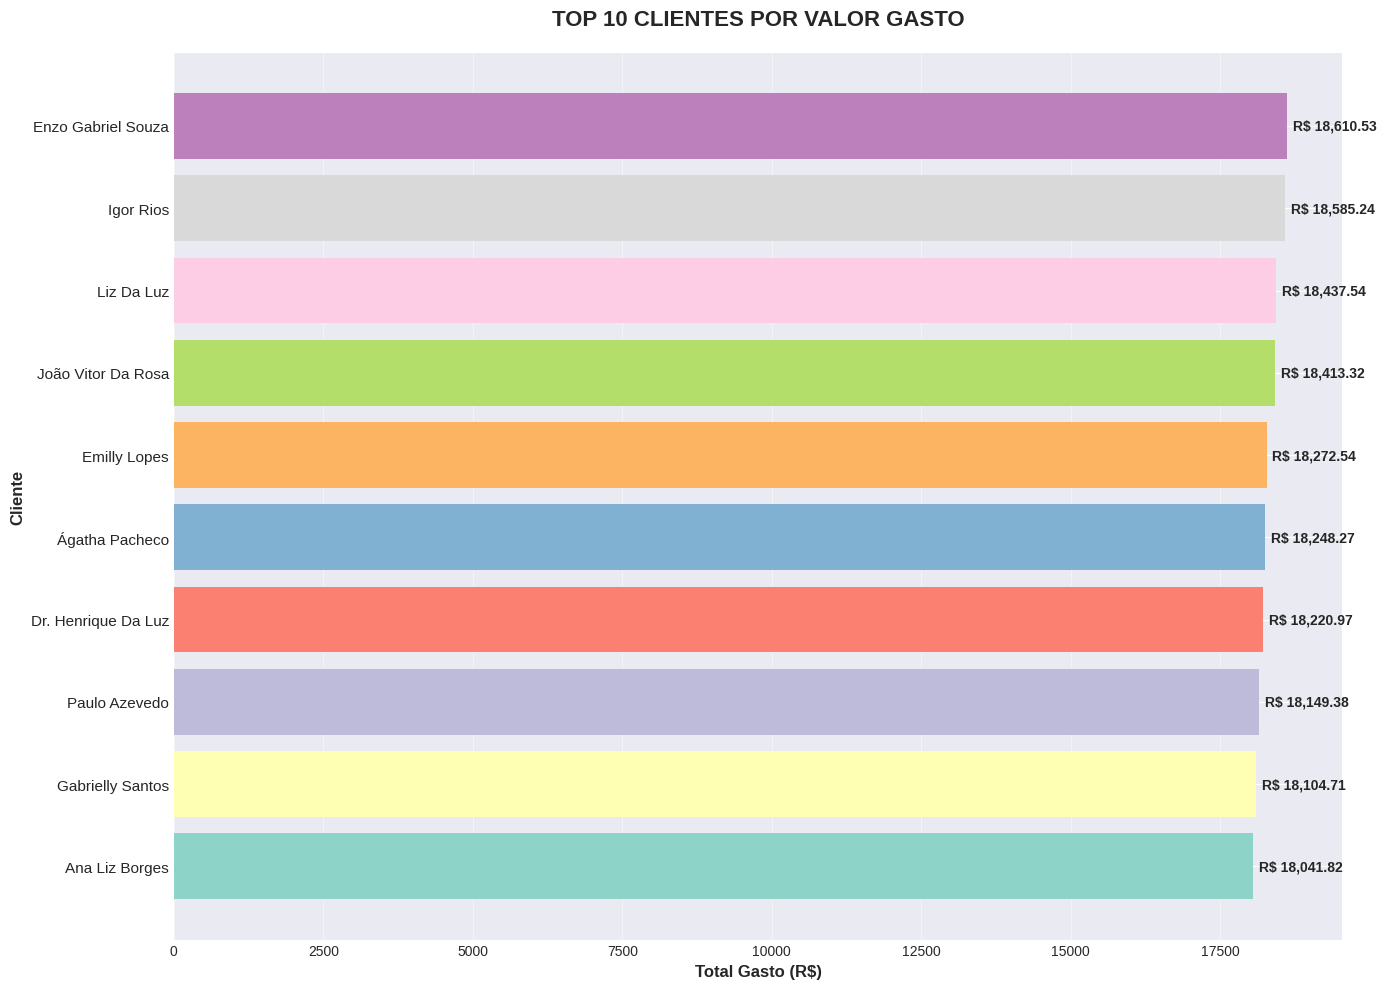

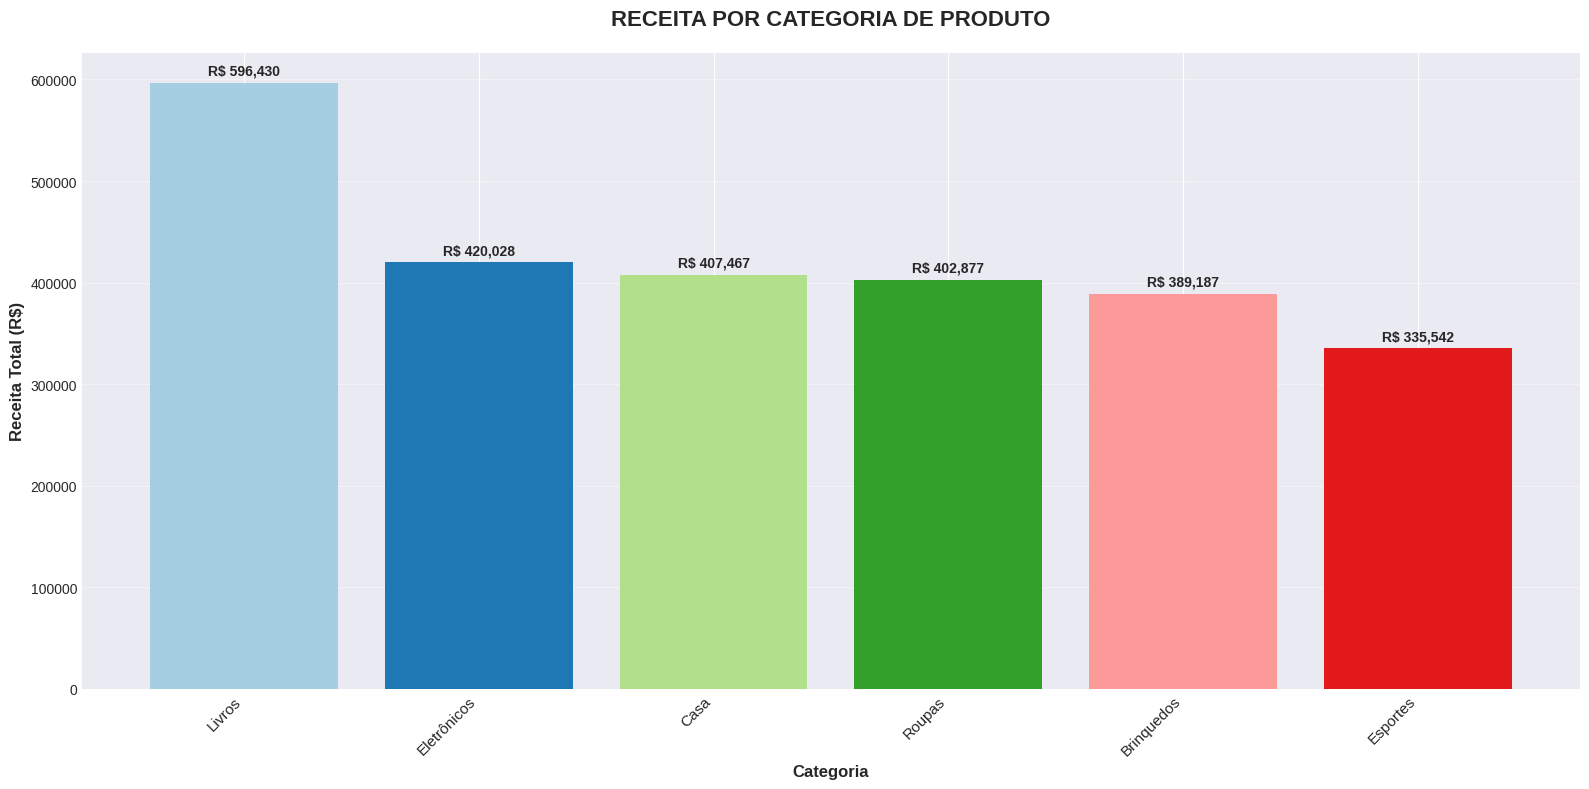

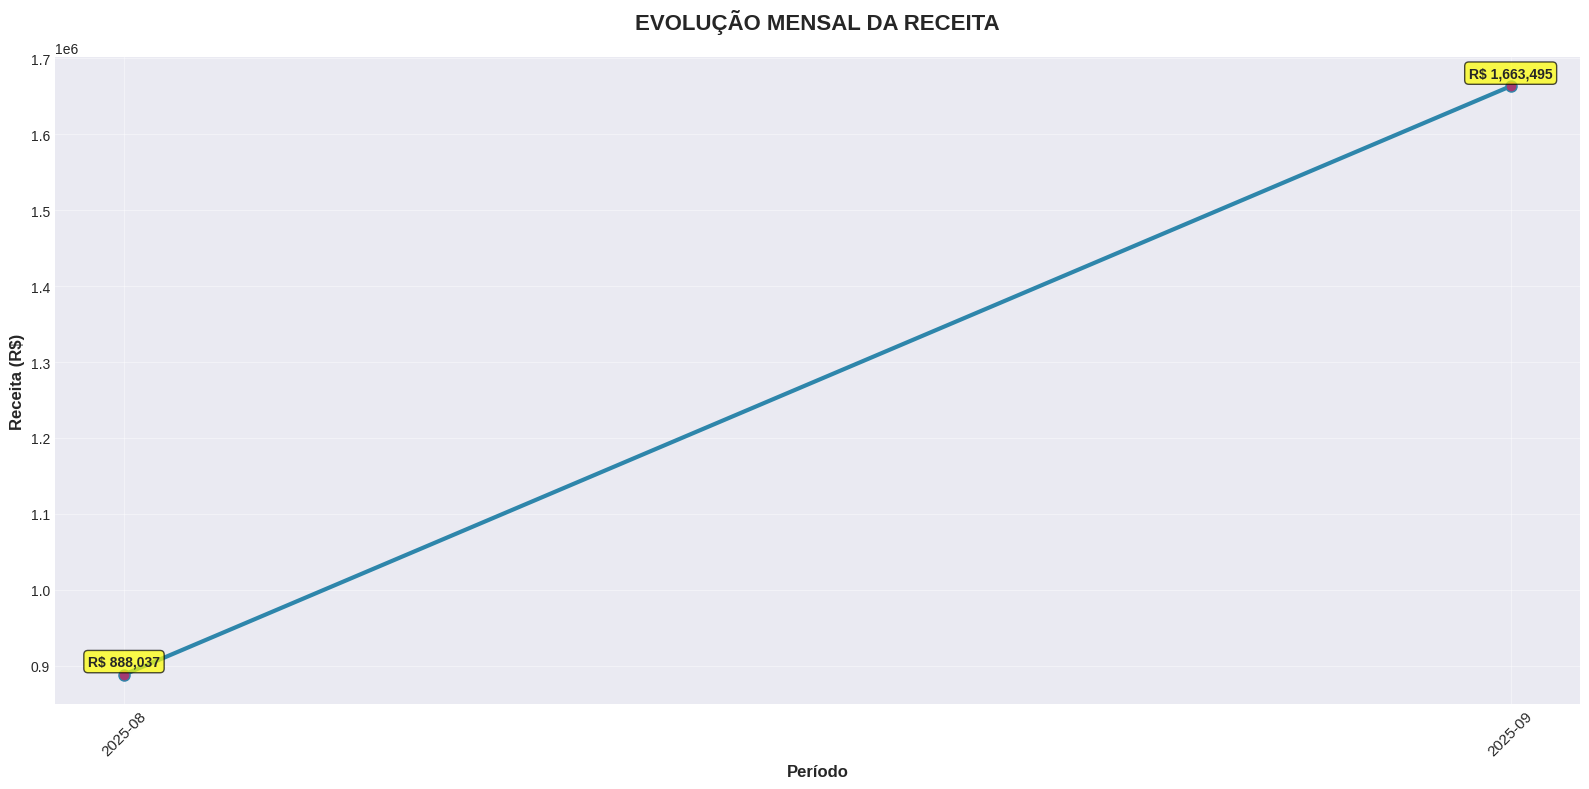

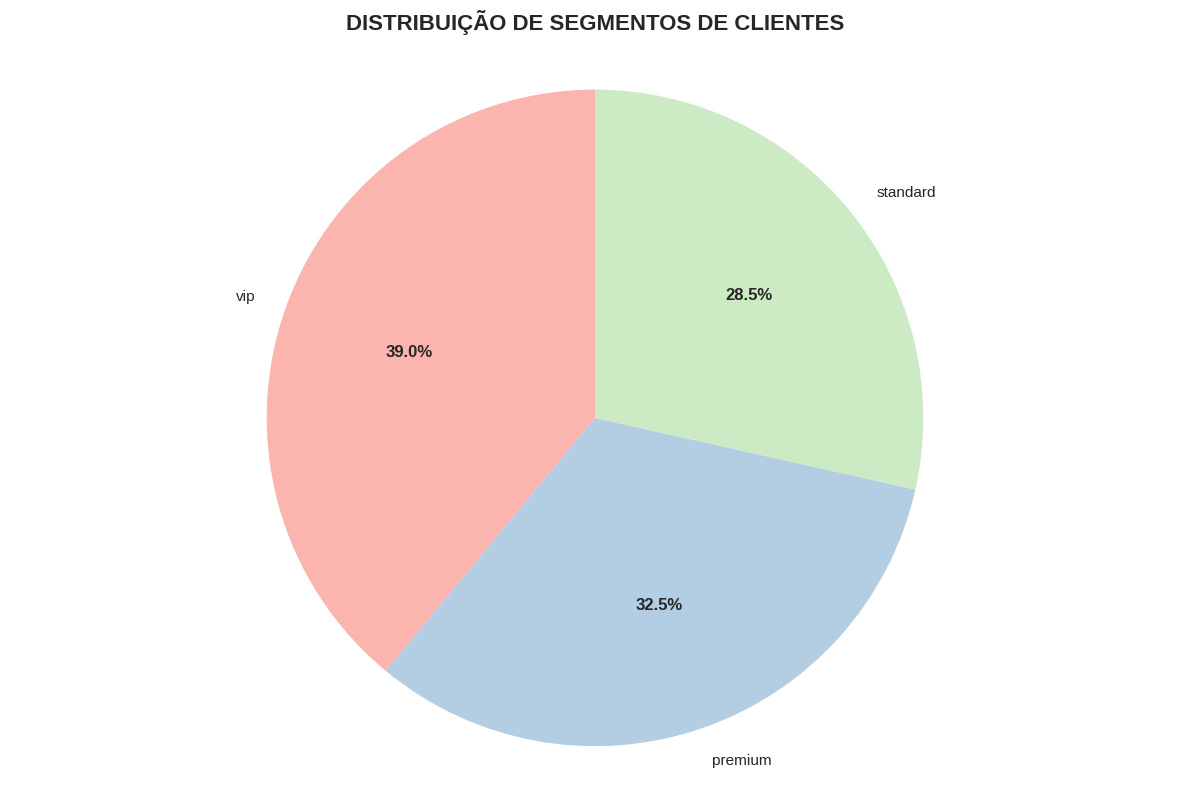

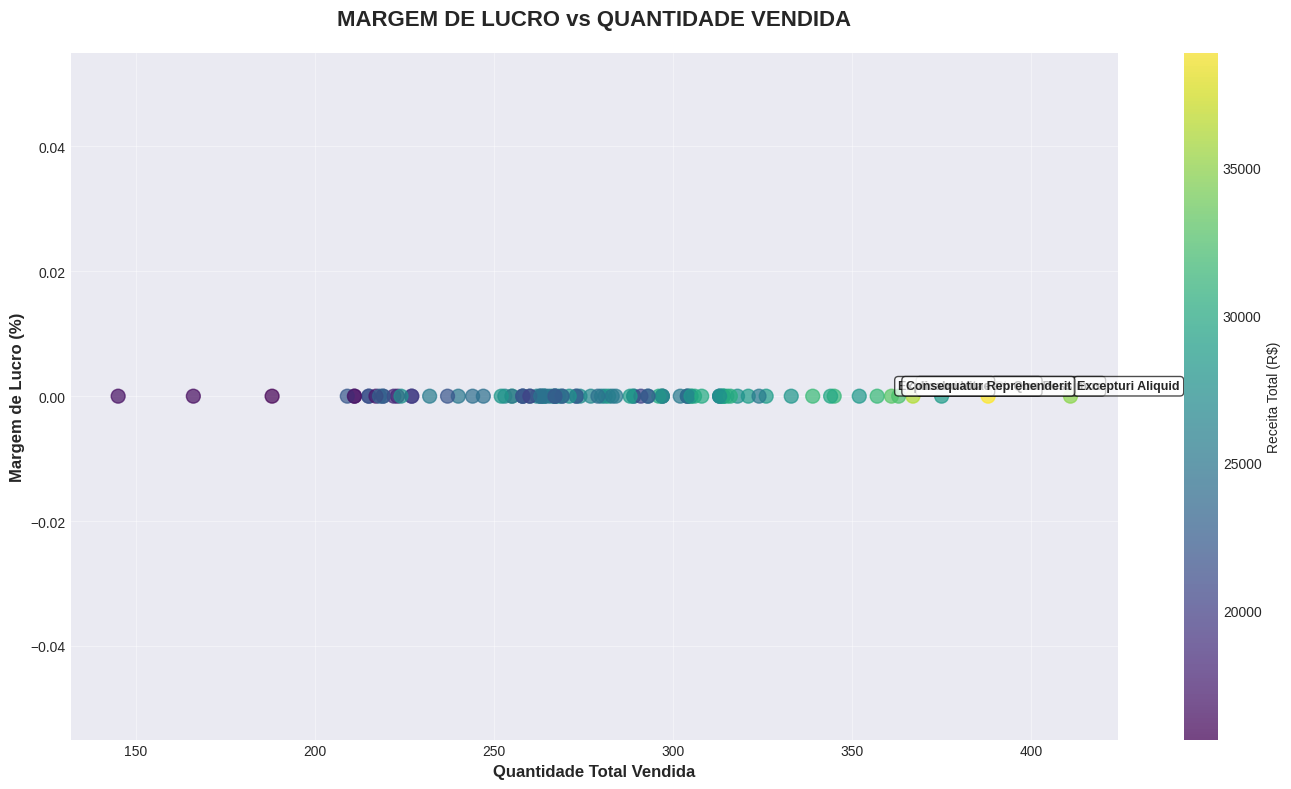

✅ Dashboards criados com sucesso!
📊 Gráficos salvos em ../data/gold/dashboards/

📋 Resumo dos gráficos criados:
   • top10_customers.png - Top 10 clientes por valor gasto
   • sales_by_category.png - Receita por categoria
   • monthly_trend.png - Evolução mensal de vendas
   • customer_segments.png - Distribuição de segmentos
   • profit_vs_quantity.png - Margem de lucro vs quantidade


In [50]:
def create_business_dashboards():
    """Cria visualizações para dashboards com estilo moderno"""
    
    print("📈 CRIANDO VISUALIZAÇÕES PARA DASHBOARDS\n")
    
    # Configurar estilo com opções disponíveis
    plt.style.use('seaborn-v0_8-darkgrid')  # Usar estilo moderno disponível
    sns.set_palette("tab10")
    
    # Ler dados
    try:
        customers = pd.read_parquet('../data/gold/customer_analytics.parquet')
        products = pd.read_parquet('../data/gold/product_analytics.parquet')
        monthly = pd.read_parquet('../data/gold/monthly_sales.parquet')
        
        # Garantir que o diretório existe
        os.makedirs('../data/gold/dashboards/', exist_ok=True)
        
        print("📊 Criando gráficos...")
        
        # 1. Top 10 clientes por gasto (Horizontal Bar Chart)
        plt.figure(figsize=(14, 10))
        top_customers = customers.nlargest(10, 'total_spent').sort_values('total_spent', ascending=True)
        
        bars = plt.barh(range(len(top_customers)), top_customers['total_spent'], 
                       color=plt.cm.Set3(range(len(top_customers))))
        
        plt.yticks(range(len(top_customers)), top_customers['customer_name'], fontsize=11)
        plt.title('TOP 10 CLIENTES POR VALOR GASTO', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Total Gasto (R$)', fontsize=12, fontweight='bold')
        plt.ylabel('Cliente', fontsize=12, fontweight='bold')
        plt.grid(axis='x', alpha=0.4)
        
        # Adicionar valores nas barras
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + 100, bar.get_y() + bar.get_height()/2, 
                    f'R$ {width:,.2f}', 
                    ha='left', va='center', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('../data/gold/dashboards/top10_customers.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 2. Vendas por categoria (Bar Chart)
        plt.figure(figsize=(16, 8))
        category_sales = products.groupby('product_category')['total_revenue'].sum().sort_values(ascending=False)
        
        colors = plt.cm.Paired(range(len(category_sales)))
        bars = plt.bar(range(len(category_sales)), category_sales.values, color=colors)
        
        plt.xticks(range(len(category_sales)), category_sales.index, rotation=45, ha='right', fontsize=11)
        plt.title('RECEITA POR CATEGORIA DE PRODUTO', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Categoria', fontsize=12, fontweight='bold')
        plt.ylabel('Receita Total (R$)', fontsize=12, fontweight='bold')
        plt.grid(axis='y', alpha=0.4)
        
        # Adicionar valores nas barras
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 5000, 
                    f'R$ {height:,.0f}', 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('../data/gold/dashboards/sales_by_category.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 3. Evolução mensal de vendas (Line Chart)
        plt.figure(figsize=(16, 8))
        monthly['period'] = monthly['order_year'] + '-' + monthly['order_month']
        monthly_grouped = monthly.groupby('period')['total_revenue'].sum()
        
        plt.plot(range(len(monthly_grouped)), monthly_grouped.values, 
                marker='o', linewidth=3, markersize=8, color='#2E86AB', markerfacecolor='#A23B72')
        
        plt.xticks(range(len(monthly_grouped)), monthly_grouped.index, rotation=45, fontsize=11)
        plt.title('EVOLUÇÃO MENSAL DA RECEITA', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Período', fontsize=12, fontweight='bold')
        plt.ylabel('Receita (R$)', fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.4)
        
        # Adicionar valores nos pontos
        for i, value in enumerate(monthly_grouped.values):
            plt.text(i, value + 8000, f'R$ {value:,.0f}', 
                    ha='center', va='bottom', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
        
        plt.tight_layout()
        plt.savefig('../data/gold/dashboards/monthly_trend.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 4. Distribuição de segmentos de clientes (Pie Chart)
        plt.figure(figsize=(12, 8))
        segment_distribution = customers['customer_segment'].value_counts()
        colors = plt.cm.Pastel1(range(len(segment_distribution)))
        
        wedges, texts, autotexts = plt.pie(segment_distribution.values, 
                                          labels=segment_distribution.index,
                                          autopct='%1.1f%%', 
                                          startangle=90,
                                          colors=colors,
                                          textprops={'fontsize': 11})
        
        plt.title('DISTRIBUIÇÃO DE SEGMENTOS DE CLIENTES', fontsize=16, fontweight='bold', pad=20)
        
        # Melhorar a aparência dos textos
        for autotext in autotexts:
            autotext.set_fontweight('bold')
            autotext.set_fontsize(12)
        
        plt.axis('equal')
        plt.tight_layout()
        plt.savefig('../data/gold/dashboards/customer_segments.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 5. Margem de lucro por produto (Scatter Plot)
        plt.figure(figsize=(14, 8))
        plt.scatter(products['total_sold'], products['profit_margin'], 
                   c=products['total_revenue'], cmap='viridis', s=100, alpha=0.7)
        
        plt.colorbar(label='Receita Total (R$)')
        plt.xlabel('Quantidade Total Vendida', fontsize=12, fontweight='bold')
        plt.ylabel('Margem de Lucro (%)', fontsize=12, fontweight='bold')
        plt.title('MARGEM DE LUCRO vs QUANTIDADE VENDIDA', fontsize=16, fontweight='bold', pad=20)
        plt.grid(True, alpha=0.4)
        
        # Adicionar alguns labels para produtos importantes
        for i, row in products.nlargest(5, 'total_revenue').iterrows():
            plt.annotate(row['product_name'], 
                        (row['total_sold'], row['profit_margin']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=9, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
        
        plt.tight_layout()
        plt.savefig('../data/gold/dashboards/profit_vs_quantity.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Dashboards criados com sucesso!")
        print("📊 Gráficos salvos em ../data/gold/dashboards/")
        print("\n📋 Resumo dos gráficos criados:")
        print("   • top10_customers.png - Top 10 clientes por valor gasto")
        print("   • sales_by_category.png - Receita por categoria")
        print("   • monthly_trend.png - Evolução mensal de vendas")
        print("   • customer_segments.png - Distribuição de segmentos")
        print("   • profit_vs_quantity.png - Margem de lucro vs quantidade")
        
    except Exception as e:
        print(f"❌ Erro ao criar dashboards: {e}")
        import traceback
        traceback.print_exc()

# Executar criação de dashboards
create_business_dashboards()